To Dos:
- Add Loss Function
- Add Optimization
- Define Variables that should be optimized

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncexpon, truncnorm, nbinom
import pandas as pd
import torch

In [2]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/CovidPrediction/

/content/drive/MyDrive/CovidPrediction


# Initialization

In [5]:
data = pd.read_csv('data/covid19model.csv')
data.head(3)

,date,hospit,serial_interval,delay_distr
0,2020-02-17,0,0.046535,0.013006
1,2020-02-18,0,0.087065,0.030046
2,2020-02-19,0,0.112061,0.044674


In [6]:
num_impute = 6
observed_daily_hospit = torch.from_numpy(data.hospit.to_numpy())
pi = torch.from_numpy(data.delay_distr.to_numpy())
serial_interval = torch.from_numpy(data.serial_interval.to_numpy())
population = 5793636
num_observations = len(observed_daily_hospit)
population_t = torch.from_numpy(np.full(shape=num_observations, fill_value=population))

Initialize latent variables / parameters

In [7]:
dtype = torch.float
device = torch.device("cpu")

tau = np.random.exponential(1 / 0.03)
tau_t = torch.tensor(tau, requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale
y = torch.tensor(truncexpon.rvs(b=(1000 - 0) / tau, loc=0, scale=tau), requires_grad=False, device=device, dtype=dtype)  # number of initial newly_infected (seed)

# For trunc ((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
phi = torch.tensor(truncnorm.rvs((0 - 0) / 5, (np.inf - 0) / 5, loc=0, scale=5), requires_grad=True, device=device, dtype=dtype)  # dispersion (shape) parameter for observations
R0 = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True, device=device, dtype=dtype)  # initial reproduction number
alpha = torch.tensor(truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100), requires_grad=True, device=device, dtype=dtype)  # probability to get hospitalized
sigma = torch.tensor(truncnorm.rvs((0 - 0.05) / 0.03, (0.15 - 0.05) / 0.03, loc=0.05, scale=0.03), requires_grad=True, device=device, dtype=dtype)  # standart deviation of random walk step

Initialize time series variables

In [8]:
newly_infected = torch.zeros(num_observations)  # number of newly infected
effectively_infectious = torch.zeros(num_observations)  # effective number of infectious individuals
expected_daily_hospit = torch.zeros(num_observations)  # expected number of daily hospitalizations
cumulative_infected = torch.zeros(num_observations)  # cumulative number of infected
eta_t = torch.zeros(num_observations)  # transformed reproduction number
epsilon_t = torch.zeros(num_observations)  # random walk
St = torch.zeros(num_observations)  # fraction of susceptible population

seed initial infection / impute first `num_impute` days

In [9]:
#newly_infected[0:num_impute] = y
for i in range(num_impute):
  newly_infected[i] = y

cumulative_infected[0] = 0.
cumulative_infected[1:num_impute] = np.cumsum(newly_infected[0:num_impute - 1])
St[0:num_impute] = torch.tensor([np.maximum(population - x, 0)/population for x in cumulative_infected[0:num_impute]])

# Calculation

Define calculation_function

In [10]:
def calc_Rt():
  #calculate Rt
  beta_0 = torch.log(R0)
  epsilon_t[0] = torch.normal(0, sigma)
  for t in range(1, num_observations):
    epsilon_t[t] = torch.normal(epsilon_t[t-1], sigma)
  eta_t = beta_0 + epsilon_t  # + RNN[X_t, t]
  Rt = torch.exp(eta_t)
  return Rt

def calc_newly_infected(Rt, newly_infected):  
  #calculate newly_infected
  for t in range(num_impute, num_observations):
    # Update cumulative newly_infected
    cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
    # effective number of infectous individuals
    effectively_infectious[t] = np.sum([newly_infected[i].clone() * serial_interval[t-i].clone() for i in range(0, t-1)]) ## To Do!!! 
  # Adjusts for portion of pop that are susceptible
  St[num_impute:] = torch.maximum(torch.tensor(population) - cumulative_infected[num_impute:].clone(), torch.tensor(0) / torch.tensor(population)) ##[num_impute:]
  # number of new infections (unobserved)
  newly_infected[num_impute:] = St[num_impute:].clone() * Rt[num_impute:].clone() * effectively_infectious[num_impute:].clone()
  return newly_infected

def calc_exp_hospit(newly_infected):
  #calculate expected_daily_hospit
  expected_daily_hospit[0] = (1e-15) * newly_infected[0]
  for t in range(1, num_observations):
    expected_daily_hospit[t] = alpha * np.sum([newly_infected[i] * pi[t - i] for i in range(0, t - 1)]) ## To Do!
  return expected_daily_hospit

def forward_pass():
  Rt = calc_Rt()
  newly_inf = calc_newly_infected(Rt, newly_infected)
  y_pred = calc_exp_hospit(newly_inf)
  return y_pred

In [11]:
y_pred = forward_pass()

# Optimization

In [12]:
y_true = observed_daily_hospit

In [13]:
learning_rate = 1e-6
torch.autograd.set_detect_anomaly(True)

#for t in range (5):
# forward pass - calculate expected_daily_hospit
y_pred = forward_pass()

loss = (y_true - y_pred).pow(2).sum()
#if t % 100 == 99:
#  print(t, loss)

loss.backward()
tau_t.grad


"""with torch.no_grad():
  tau_t -= learning_rate * tau_t.grad
  phi -= learning_rate * phi.grad
  R0 -= learning_rate * R0.grad
  alpha -= learning_rate * alpha.grad
  sigma -= learning_rate * sigma.grad

  tau_t.grad = None
  phi.grad = None
  R0.grad = None
  alpha.grad = None
  sigma.grad = None"""
  
#print(f'Result: tau = {tau_t.item()}, phi = {phi.item()}, R0 = {R0.item()}, alpha = {alpha.item()}, sigma = {sigma.item()},')

'with torch.no_grad():\n  tau_t -= learning_rate * tau_t.grad\n  phi -= learning_rate * phi.grad\n  R0 -= learning_rate * R0.grad\n  alpha -= learning_rate * alpha.grad\n  sigma -= learning_rate * sigma.grad\n\n  tau_t.grad = None\n  phi.grad = None\n  R0.grad = None\n  alpha.grad = None\n  sigma.grad = None'

In [14]:
tau_t.grad.dtype

AttributeError: ignored

In [15]:
print(loss)

tensor(2.1500e+11, grad_fn=<SumBackward0>)


In [18]:
print(tau_t)

tensor(24.2165, requires_grad=True)


TypeError: ignored

compare observed hospitalizations to model results

In [16]:
expected_daily_hospit_np = y_pred.detach().numpy()

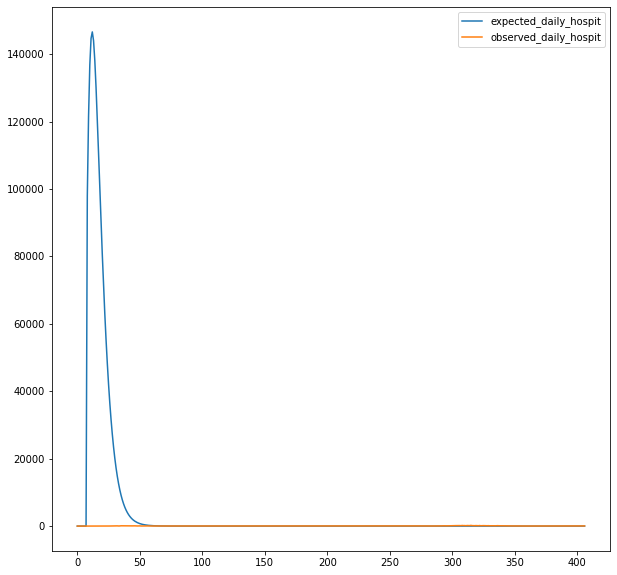

In [17]:
plt.figure(figsize=(10,10))
plt.plot(expected_daily_hospit_np, label='expected_daily_hospit')
plt.plot(observed_daily_hospit, label='observed_daily_hospit')
plt.legend()
plt.show()